In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

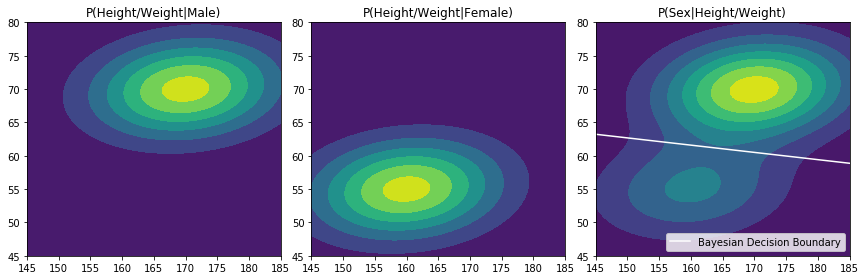

In [2]:
### Define Joint Distribution p(C,x) = p(C)p(x|C)
## Set p(C)
male = 0.7; female = 0.3

## Set P(x|C): height & weight of male and female
mu_male = np.array([170, 70]); mu_female = np.array([160, 55])
sigma = np.array([[10**2, 0.5*5*2.5],[0.5*5*2.5, 5**2]])
HW_male = multivariate_normal(mu_male, sigma)
HW_female = multivariate_normal(mu_female, sigma)

## Get Joint Distribution p(C,x) = p(C)p(x|C)
# some messy prep works
ht = np.linspace(145, 185, 500); wt = np.linspace(45, 80, 500)
H, W = np.meshgrid(ht, wt); pos = np.dstack((H,W))
# use p(C,x) = p(C)p(x|C)
HW_sex = HW_male.pdf(pos) * male + HW_female.pdf(pos) * female

### Visualize p(C,x) = p(C)p(x|C)
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
ax1.contourf(H, W, HW_male.pdf(pos))
ax1.set(title='P(Height/Weight|Male)')

ax2 = fig.add_subplot(132)
ax2.contourf(H, W, HW_female.pdf(pos))
ax2.set(title='P(Height/Weight|Female)')

ax3 = fig.add_subplot(133)
ax3.contourf(H, W, HW_sex)
ax3.set(title='P(Sex|Height/Weight)')

# plot Bayesian Decision Boundary
inv = np.linalg.inv
m1 = np.matrix(mu_male).T; m2 = np.matrix(mu_female).T
w = inv(sigma) @ (m1 - m2)
w0 = -0.5 * m1.T @ inv(sigma) @ m1 + 0.5 * m2.T @ inv(sigma) @ m2 + np.log(male/female)
bdb = -w0/w[1] - w[0]/w[1] * ht
ax3.plot(ht, bdb.T, label='Bayesian Decision Boundary', color='white')
ax3.legend(loc='lower right')

fig.tight_layout()

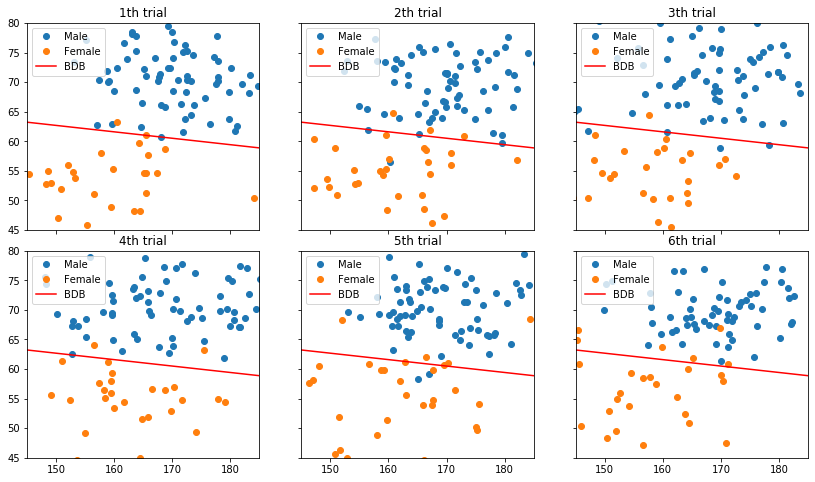

In [3]:
N = 10000

fig, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(14,8))
fig.subplots_adjust(hspace=0.1, wspace=0.18)
for i, axi in enumerate(axes.flat, 1):
    
    # Generate samples of male/female
    N_male = int(100 * male); N_female = int(100 * female)
    male_data = HW_male.rvs(N_male)
    female_data = HW_female.rvs(N_female)
    
    # Plot results
    axi.set(xlim=(145, 185), ylim=(45, 80), title='{0}th trial'.format(i))
    axi.plot(male_data[:,0], male_data[:,1], linestyle='', marker='o', label='Male')
    axi.plot(female_data[:,0], female_data[:,1], linestyle='', marker='o', label='Female')
    axi.plot(ht, bdb.T, label='BDB', color='red')
    axi.legend(loc='upper left')


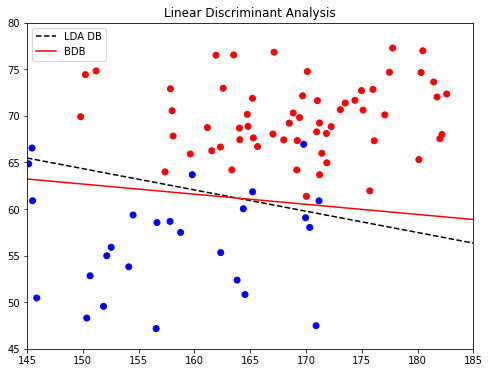

In [4]:
# Rearrange Training data set for LDA fitting
X = np.vstack((male_data, female_data))
y = np.hstack((np.repeat(1, male_data.shape[0]), np.repeat(0, female_data.shape[0])))

# Call LDA function from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(X,y)
w = clf.coef_; w0 = clf.intercept_
db = -w0/w[:,1] - w[:,0]/w[:,1] * ht

fig, ax = plt.subplots(figsize=(8,6))
ax.set(xlim=(145, 185), ylim=(45, 80), title='Linear Discriminant Analysis')
colors=np.array(['blue','red'])
ax.scatter(X[:,0], X[:,1], color=colors[y])
ax.plot(ht, db.T, label='LDA DB', color='black', linestyle='--')
ax.plot(ht, bdb.T, label='BDB', color='red')
ax.legend()

QDA train Error:  0.91
LDA train Error:  0.87


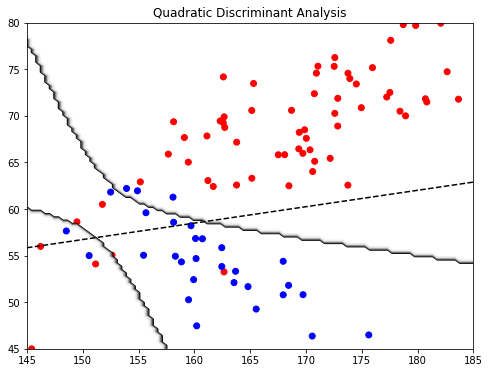

In [5]:
### Generate MVN samples with heterogenous covariance matrix
sigma1 = np.array([[10**2, 0.8*10*8],[0.8*10*8, 8**2]])
sigma2 = np.array([[6**2, -0.7*6*4],[-0.7*6*4, 4**2]])
HW_male = multivariate_normal(mu_male, sigma1)
HW_female = multivariate_normal(mu_female, sigma2)
male_data = HW_male.rvs(N_male)
female_data = HW_female.rvs(N_female)

## Rearrange Training data set for LDA fitting
X = np.vstack((male_data, female_data))
y = np.hstack((np.repeat(1, male_data.shape[0]), np.repeat(0, female_data.shape[0])))

## Call QDA function from sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis().fit(X,y)
print('QDA train Error: ', clf.score(X,y))

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set(xlim=(145, 185), ylim=(45, 80), title='Quadratic Discriminant Analysis')
colors=np.array(['blue','red'])
ax1.scatter(X[:,0], X[:,1], color=colors[y])

## Plot LDA Decision Boundary
clf_lda = LinearDiscriminantAnalysis().fit(X,y)
w = clf_lda.coef_; w0 = clf_lda.intercept_
db = -w0/w[:,1] - w[:,0]/w[:,1] * ht
ax1.plot(ht, db.T, color='black', linestyle='--')
print('LDA train Error: ', clf_lda.score(X,y))

## Plot QDA Decision Boundary
r1 = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
r2 = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100)
R1, R2 = np.meshgrid(r1, r2)
R = np.c_[R1.ravel(), R2.ravel()]
Z = clf.predict(R).reshape(R1.shape)
ax1.contour(R1, R2, Z, cmap="Greys_r")

[Text(0.5, 0, 'Iteration'), Text(0.5, 1.0, 'Cross Entropy Loss')]

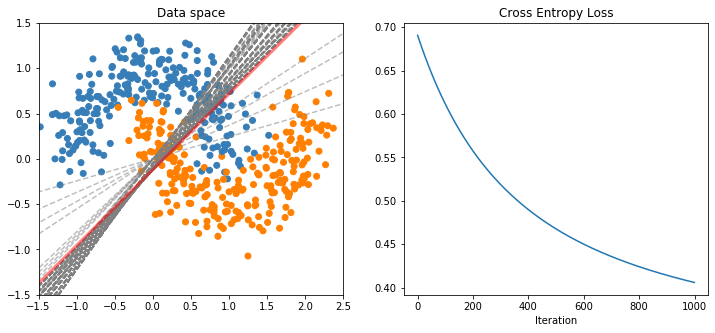

In [6]:
## Generate Toy Sample
import sklearn.datasets
X, Y = sklearn.datasets.make_moons(n_samples=500, noise=0.2)
colors = np.array(['#377eb8', '#ff7f00'])
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.scatter(X[:,0], X[:, 1], color=colors[Y])
ax1.set(xlim=(-1.5, 2.5), ylim=(-1.5, 1.5), title='Data space')

X, Y = X.T, Y.reshape(1, Y.shape[0]) # add dimension

## Set learing parameters
epochs = 1000
eta = 0.01

## Define Sigmoid function
def sigmoid(z): 
    return 1/(1+np.exp(-z))

## Initialize coefficients
m = X.shape[1]
w = np.random.randn(X.shape[0], 1)*0.01 # nearly zero but not zero exactly
b = 0

## Iterative Update
losstrack=[]
for epoch in range(epochs):
    # log-odd
    z = np.dot(w.T, X) + b
    
    # prediction by z
    p = sigmoid(z) 
    
    # cross entropy error averaged
    cost = -np.sum(np.multiply(np.log(p), Y) + np.multiply((1-Y), np.log(1-p)))/m 
    losstrack.append(np.squeeze(cost))
    
    # Move coefficients by...
    dz = p-Y
    dw = (1/m) * np.dot(X, dz.T)
    db = (1/m) * np.sum(dz)
    w = w - eta * dw
    b = b - eta * db
    
    # Plot Decision Boundary
    if epoch & 100 == 0:
        db = -b/w[1] - w[0]/w[1] * np.linspace(-3, 3, 100)
        ax1.plot(np.linspace(-3, 3, 100), db.T, label='Decision Boundary', 
                 linestyle='--',color='grey', alpha=0.5)

## Plot Results
db = -b/w[1] - w[0]/w[1] * np.linspace(-3, 3, 100)
ax1.plot(np.linspace(-3, 3, 100), db.T, label='Decision Boundary', 
         linewidth=3, color='red', alpha=0.5)

ax2 = fig.add_subplot(122)
ax2.plot(losstrack)
ax2.set(title='Cross Entropy Loss', xlabel='Iteration')

0.85


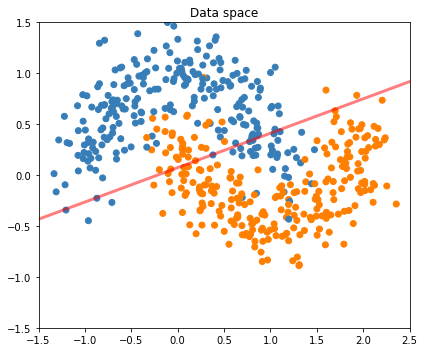

In [7]:
from sklearn.linear_model import LogisticRegression
X, Y = sklearn.datasets.make_moons(n_samples=500, noise=0.2)
clf = LogisticRegression(solver='sag', max_iter=100).fit(X, Y)
clf.predict(X[:100,:]) # return class
clf.predict_proba(X[:100,:]) # return probability
print(clf.score(X, Y)) # return 1- Error rate in Training set

## Plot Decision Surface
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax1.scatter(X[:,0], X[:, 1], color=colors[Y])
ax1.set(xlim=(-1.5, 2.5), ylim=(-1.5, 1.5), title='Data space')
w = clf.coef_; b = clf.intercept_
db = -b/w[:,1] - w[:,0]/w[:,1] * np.linspace(-3, 3, 100)
ax1.plot(np.linspace(-3, 3, 100), db.T, label='Decision Boundary', 
         linewidth=3, color='red', alpha=0.5)
fig.tight_layout()

0.948


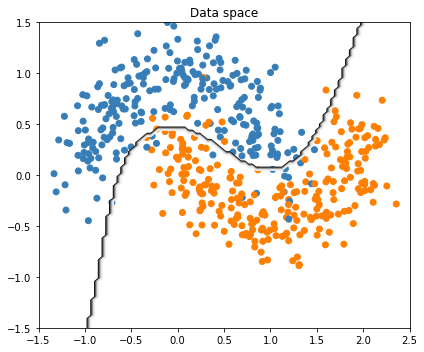

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False) # No column of 1s
X_poly = poly.fit_transform(X)
clf = LogisticRegression().fit(X_poly, Y)
print(clf.score(X_poly, Y)) # return 1- Error rate in Training set

## Plot Results
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax1.scatter(X[:,0], X[:, 1], color=colors[Y])
ax1.set(xlim=(-1.5, 2.5), ylim=(-1.5, 1.5), title='Data space')

## Plot Decision Surface
r1 = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100)
r2 = np.linspace(ax1.get_ylim()[0], ax1.get_ylim()[1], 100)
R1, R2 = np.meshgrid(r1, r2)
R = np.c_[R1.ravel(), R2.ravel()]
R_poly = poly.fit_transform(R)
Z = clf.predict(R_poly).reshape(R1.shape)
plt.contour(R1, R2, Z, cmap="Greys_r")

fig.tight_layout()

In [9]:
import seaborn as sns; sns.set()

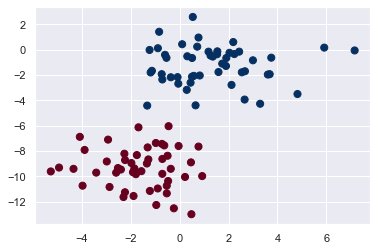

In [10]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

[(-15, 4), (-8, 8)]

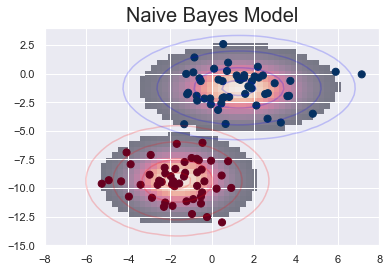

In [17]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=20)

xlim = (-8, 8)
ylim = (-15, 4)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5)
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

In [18]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

(-5.902170524311957, 7.789182875858786, -13.793829460308247, 3.381339464828492)

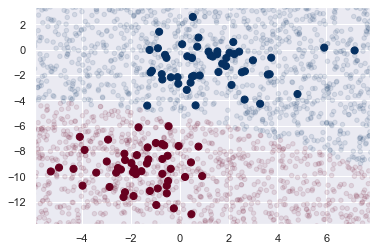

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim)

In [21]:
yprob = model.predict_proba(Xnew)
yprob[-8:]

array([[8.94552662e-01, 1.05447338e-01],
       [1.00000000e+00, 1.74106290e-14],
       [1.00000000e+00, 3.81641144e-13],
       [9.99999920e-01, 8.03870437e-08],
       [9.99680977e-01, 3.19022908e-04],
       [9.99994010e-01, 5.99039932e-06],
       [1.01364165e-09, 9.99999999e-01],
       [1.53083494e-01, 8.46916506e-01]])

In [22]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [23]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train.data, train.target)
labels = model.predict(test.data)

Text(89.133125, 0.5, 'predicted label')

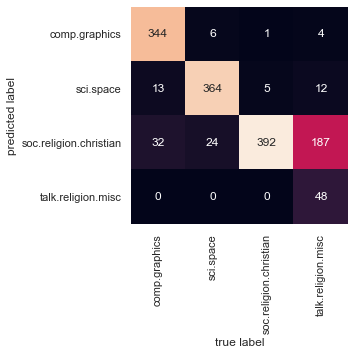

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [27]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [42]:
import pandas as pd
fname = 'C:\\Users\\이가은\\Desktop\\Wine.csv'
wine = pd.read_csv(fname, header=1)
wine

,1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050
0,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
2,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
3,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
4,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
172,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
173,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
174,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840
